# Basic Setting

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from math import pi, ceil
plt.style.use('seaborn')
sns.set_style("whitegrid")

import random
import numpy as np
import pandas as pd
import random
import math
import itertools
import multiprocessing
from tqdm import tqdm
import logging
import pickle

from scipy.sparse.linalg import svds,eigs
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances

from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from scipy import stats

from time import time
import warnings
warnings.filterwarnings(action='ignore')

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ATK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
track = pd.read_csv('2315_global_track_spotify.csv')
track = pd.DataFrame(track)
# track = track.rename(columns={'Unnamed: 0':'index'})
# track_t = track.drop(['artist_name', 'track_name', 'album_name', ])
print(track.shape)
track.head()

(2315, 22)


,Unnamed: 0,id,artist_name,track_name,album_name,artist_genre,release_date,artist_popularity,track_popularity,artist_followers,...,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,4Dvkj6JhhA12EX05fT7y2e,Harry Styles,As It Was,Harry's House,['pop'],2022-05-20,94,94,21468616,...,6,-5.338,0.0557,0.3420,0.001010,0.3110,0.662,173.930,167303,4
1,1,75FEaRjZTKLhTrFGsfMUXR,Kate Bush,Running Up That Hill (A Deal With God),Hounds Of Love,"['art pop', 'art rock', 'baroque pop', 'new wa...",1985,80,94,1124451,...,10,-13.123,0.0550,0.7200,0.003140,0.0604,0.197,108.375,298933,4
2,2,6Sq7ltF9Qa7SNFBsV5Cogx,Bad Bunny,Me Porto Bonito,Un Verano Sin Ti,"['latin', 'reggaeton', 'trap latino']",2022-05-06,100,99,50042765,...,1,-5.105,0.0817,0.0901,0.000027,0.0933,0.425,92.005,178567,4
3,3,6xGruZOHLs39ZbVccQTuPZ,Joji,Glimpse of Us,Glimpse of Us,"['alternative r&b', 'viral pop']",2022-06-10,82,93,6078047,...,8,-9.258,0.0531,0.8910,0.000005,0.1410,0.268,169.914,233456,3
4,4,3k3NWokhRRkEPhCzPmV8TW,Bad Bunny,Ojitos Lindos,Un Verano Sin Ti,"['latin', 'reggaeton', 'trap latino']",2022-05-06,100,98,50042765,...,3,-5.745,0.0413,0.0800,0.000001,0.5280,0.268,79.928,258299,4


# Feature Engineering 

In [26]:
import re
 
def cleanText(readData):
    text = re.sub('[-=+#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','', readData) # 쉼표(,) 뺌
 
    return text

In [27]:
genre = []
for i in track['artist_genre']:
    if i == '[]':
        i = 'NA'
        genre.append(i.strip()) #"'[]'"
    else:
        i = cleanText(i)
        genre.append(i.strip())
track['genre'] = genre

In [28]:
track = track[track['genre'] != "NA"]
track = track.reset_index()
track['track_popularity'] = track['track_popularity'] / 100 

In [29]:
track.head()

,index,Unnamed: 0,id,artist_name,track_name,album_name,artist_genre,release_date,artist_popularity,track_popularity,...,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre
0,0,0,4Dvkj6JhhA12EX05fT7y2e,Harry Styles,As It Was,Harry's House,['pop'],2022-05-20,94,0.94,...,-5.338,0.0557,0.3420,0.001010,0.3110,0.662,173.930,167303,4,pop
1,1,1,75FEaRjZTKLhTrFGsfMUXR,Kate Bush,Running Up That Hill (A Deal With God),Hounds Of Love,"['art pop', 'art rock', 'baroque pop', 'new wa...",1985,80,0.94,...,-13.123,0.0550,0.7200,0.003140,0.0604,0.197,108.375,298933,4,"art pop, art rock, baroque pop, new wave pop, ..."
2,2,2,6Sq7ltF9Qa7SNFBsV5Cogx,Bad Bunny,Me Porto Bonito,Un Verano Sin Ti,"['latin', 'reggaeton', 'trap latino']",2022-05-06,100,0.99,...,-5.105,0.0817,0.0901,0.000027,0.0933,0.425,92.005,178567,4,"latin, reggaeton, trap latino"
3,3,3,6xGruZOHLs39ZbVccQTuPZ,Joji,Glimpse of Us,Glimpse of Us,"['alternative r&b', 'viral pop']",2022-06-10,82,0.93,...,-9.258,0.0531,0.8910,0.000005,0.1410,0.268,169.914,233456,3,"alternative rb, viral pop"
4,4,4,3k3NWokhRRkEPhCzPmV8TW,Bad Bunny,Ojitos Lindos,Un Verano Sin Ti,"['latin', 'reggaeton', 'trap latino']",2022-05-06,100,0.98,...,-5.745,0.0413,0.0800,0.000001,0.5280,0.268,79.928,258299,4,"latin, reggaeton, trap latino"


## Collecting User info

In [30]:
# import random
# songs = list(track['track_name'].values)
# song = random.sample(songs, 5)

# total_dictionary = {}
# qs=[]
# qs.append("무슨 곡이 가장 좋아요?   1) {}  2) {}  3) {}  4) {}  5) {}".format(song[0],song[1],song[2],song[3],song[4]))
# qs.append("어떤 분위기의 곡을 좋아하세요?   1) 밝은  2) 어두운")
# qs.append("어느정도의 속도를 가직 곡을 좋아하시나요?   1) 빠름  2) 느림")
# qs.append("고객님께서는 현재 감정이 어떤 상태이신가요?   1) 신남  2) 평범  3) 슬픔")
# qs.append("끝")


# for q in qs:
#     question = q
#     if question == "끝":
#         break
#     else:
#         total_dictionary[question] = ""

# for i in total_dictionary:
#     print(i)
#     answer = input()
#     total_dictionary[i] = answer 

# a = list(total_dictionary.items())
# answer_1 = a[0][1]
# answer_2 = a[1][1]
# answer_3 = a[2][1]
# answer_4 = a[3][1]

## Genre Recommeder

In [31]:
# def recommend_genre(data, music_name, top=200):

#     # TF-IDF
#     tfidf = TfidfVectorizer(ngram_range=(1,2))
#     tf_genre = tfidf.fit_transform(data.genre)

#     # 코사인 유사도
#     ts_genre = cosine_similarity(tf_genre, tf_genre)

#     #특정 장르 정보 뽑아오기
#     target_genre_index = data[data['track_name'] == music_name].index.values

#     # 입력한 영화의 유사도 데이터 프레임 추가
#     data["cos_similarity"] = ts_genre[target_genre_index, :].reshape(-1,1)
#     sim_genre_index = data[data.index != target_genre_index[0]].index
#     sim_genre = data.iloc[sim_genre_index].sort_values(by="cos_similarity", ascending=False)
#     final_index = sim_genre.index.values[ : top]
#     result_genre = data.iloc[final_index]
    
#     return result_genre[['artist_name', 'track_name', 'cos_similarity']]

## Genre + Artist/Track/Album name Recommeder

In [32]:
# def recommend_genre(data, music_name, top=200):

#     # TF-IDF
#     tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,2) ,stop_words=stopwords.words('english'))
#     tf_genre = tfidf.fit_transform(data['artist_name'] + ' ' +
#                                    data['track_name'] + ' ' +
#                                    data['album_name'] + ' ' +
#                                    data['genre'])

#     # 코사인 유사도
#     ts_genre = cosine_similarity(tf_genre, tf_genre)

#     #특정 장르 정보 뽑아오기
#     target_genre_index = data[data['track_name'] == music_name].index.values

#     # 입력한 영화의 유사도 데이터 프레임 추가
#     data["cos_similarity"] = ts_genre[target_genre_index, :].reshape(-1,1)
#     sim_genre_index = track[track.index != target_genre_index[0]].index
#     sim_genre = data.iloc[sim_genre_index].sort_values(by="cos_similarity", ascending=False)
#     final_index = sim_genre.index.values[ : top]
#     result_genre = data.iloc[final_index]
    
#     return result_genre[['artist_name', 'track_name', 'cos_similarity']]

## Features Recommender

In [33]:
# def recommend_features(track, x, top=200):
    
#     scaler = MinMaxScaler()
#     index = track[track['track_name'] == x].index.values
#     track1 = track[['danceability', 'energy', 'valence', 'tempo', 'acousticness']]
#     track_scaled = scaler.fit_transform(track1)
#     target_index = track_scaled[index]
    
#     euclidean = []
#     for value in track_scaled:
#         eu = euclidean_distance(target_index, value)
#         euclidean.append(eu)
    
#     track['euclidean_distance'] = euclidean
#     sim_feature_index = track[track.index != index[0]].index

#     result_feature = track.iloc[sim_feature_index].sort_values(by='euclidean_distance', ascending=True)[:200]
# #     result = track.iloc[sim_feature_index][:10]


#     return result_feature[['artist_name', 'track_name', 'euclidean_distance']]

## Intersection of Genre & Feature

In [34]:
# def feature_genre_intersection(a, b):
#     intersected = pd.merge(a, b, how='inner')
#     similarity = intersected[['euclidean_distance', 'cos_similarity']]
#     temp =scaler.fit_transform(similarity)
#     temp = pd.DataFrame(temp, columns = ['euclidean_scaled', 'cosine_scaled'])

#     intersected['euclidean_scaled'] = temp['euclidean_scaled']
#     intersected['cosine_scaled'] = temp['cosine_scaled']

#     intersected['ratio'] = intersected['euclidean_scaled'] + (1 - intersected['cosine_scaled'])
#     result = intersected.sort_values('ratio', ascending=True)[:10]
#     return result

## Cosine Similarity and Euclidean Distance

In [35]:
class ContentTFIDF:
    
    def __init__(self, data):
        self.data = data

    def calculateTFIDF(self):
        tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,2) ,stop_words=stopwords.words('english'))
        tfidf_content = tfidf.fit_transform(self.data['genre'])
        return tfidf_content

In [36]:
def euclidean_distance(x, y):   
    return np.sqrt(np.sum((x - y) ** 2))

In [37]:
ct = ContentTFIDF(track)
ct_tfidf = ct.calculateTFIDF()
ct_tfidf.shape

(2077, 728)

# Content-Based Recommeder
- When a User first signs up on website

In [38]:
# 진호
# class ContentBasedRecommender_1:
    
#     def __init__(self, data):
#         self.data = data
#         self.music = ''
#         self.mood = ''
#         self.speed = ''
#         self.emotion = ''

        
#     def user_info(self):
#         print("--------------------------------------------------------------------\n\
# 노래를 추천해드리기 전에 잠시 당신에 대해서 알아보겠습니다 \n\
# --------------------------------------------------------------------")
#         songs = list(self.data['track_name'].values)
#         song = random.sample(songs, 5)

#         total_dictionary = {}
#         qs=[]
#         qs.append("무슨 곡이 가장 좋아요?   1) {}  2) {}  3) {}  4) {}  5) {}".format(song[0],song[1],song[2],song[3],song[4]))
#         qs.append("어떤 분위기의 곡을 좋아하세요?   1) 밝은  2) 어두운")
#         qs.append("어느정도의 속도를 가직 곡을 좋아하시나요?   1) 빠름  2) 느림")
#         qs.append("고객님께서는 현재 감정이 어떤 상태이신가요?   1) 신남  2) 평범  3) 슬픔")
#         qs.append("끝")

#         for q in qs:
#             question = q
#             if question == "끝":
#                 break
#             else:
#                 total_dictionary[question] = ""

#         for i in total_dictionary:
#             print(i)
#             answer = input()
#             total_dictionary[i] = answer 

#         a = list(total_dictionary.items())
#         self.music = a[0][1]
#         self.mood = a[1][1]
#         self.speed = a[2][1]
#         self.emotion = a[3][1]
        
#         return [self.music, self.mood, self.speed, self.emotion]
    
    
#     def recommend_features(self, music_name, top=200):
    
#         scaler = MinMaxScaler()
#         index = self.data[self.data['track_name'] == music_name].index.values
#         track_new = self.data[['danceability', 'energy', 'valence', 'tempo', 'acousticness']]
#         track_scaled = scaler.fit_transform(track_new)
#         target_index = track_scaled[index]

#         euclidean = []
#         for value in track_scaled:
#             eu = euclidean_distance(target_index, value)
#             euclidean.append(eu)

#         self.data['euclidean_distance'] = euclidean
#         sim_feature_index = self.data[self.data.index != index[0]].index

#         result_features = self.data.iloc[sim_feature_index].sort_values(by='euclidean_distance', ascending=True)[:top]
#     #     result = track.iloc[sim_feature_index][:10]

#         return result_features[['artist_name', 'track_name', 'euclidean_distance']]

    
#     def recommend_genre(self, music_name, top=200):
        
#         # TF-IDF
#         tfidf = TfidfVectorizer(ngram_range=(1,2))
#         tf_genre = tfidf.fit_transform(self.data.genre)

#         # 코사인 유사도
#         ts_genre = cosine_similarity(tf_genre, tf_genre)

#         #특정 장르 정보 뽑아오기
#         target_genre_index = self.data[self.data['track_name'] == music_name].index.values

#         # 입력한 영화의 유사도 데이터 프레임 추가
#         self.data["cos_similarity"] = ts_genre[target_genre_index, :].reshape(-1,1)
#         sim_genre_index = self.data[self.data.index != target_genre_index[0]].index
#         sim_genre = self.data.iloc[sim_genre_index].sort_values(by="cos_similarity", ascending=False)
#         final_index = sim_genre.index.values[ : top]
#         result_genre = self.data.iloc[final_index]

#         return result_genre[['artist_name', 'track_name', 'cos_similarity']]

    
#     def feature_genre_intersection(self, recommended_feature, recommended_genre, top=10):
        
#         print("--------------------------------------------------------------\n\
# 장르 / 노래 분위기 / 노래 속도 / User 기분상태에 따라 추천을 해드리겠습니다 \n\
# --------------------------------------------------------------")
        
#         intersection = pd.merge(recommended_feature, recommended_genre, how='inner')
#         similarity = intersection[['euclidean_distance', 'cos_similarity']]
#         scaler = MinMaxScaler()
#         scale = scaler.fit_transform(similarity)
#         scale = pd.DataFrame(scale, columns=['eu_scaled', 'cos_scaled'])
        
#         intersection['euclidean_scaled'] = scale['eu_scaled']
#         intersection['cosine_scaled'] = scale['cos_scaled']
#         intersection['ratio'] = intersection['euclidean_scaled'] + (1 - intersection['cosine_scaled'])
#         result_intersection = intersection.sort_values('ratio', ascending=True)
        
#         return result_intersection[:top]

    
# a = ContentBasedRecommender_1(track)
# b = a.user_info()
# c = a.recommend_features(b[0])
# d = a.recommend_genre(b[0])
# e = a.feature_genre_intersection(c,d)
# e


In [39]:
# 연재
# class ContentBasedRecommender_1:
    
#     def __init__(self, data, tfidf_matrix):
#         self.data = data
#         self.tfidf_matrix = tfidf_matrix
#         self.music = ''
#         self.mood = ''
#         self.speed = ''
#         self.emotion = ''

        
#     def user_info(self):
#         print("--------------------------------------------------------------------\n\
# 노래를 추천해드리기 전에 잠시 당신에 대해서 알아보겠습니다 \n\
# --------------------------------------------------------------------")
#         songs = list(self.data['track_name'].values)
#         song = random.sample(songs, 5)

#         total_dictionary = {}
#         qs=[]
#         qs.append("무슨 곡이 가장 좋아요?   1) {}  2) {}  3) {}  4) {}  5) {}".format(song[0],song[1],song[2],song[3],song[4]))
#         qs.append("어떤 분위기의 곡을 좋아하세요?   1) 밝은  2) 어두운")
#         qs.append("어느정도의 속도를 가직 곡을 좋아하시나요?   1) 빠름  2) 느림")
#         qs.append("고객님께서는 현재 감정이 어떤 상태이신가요?   1) 신남  2) 평범  3) 슬픔")
#         qs.append("끝")

#         for q in qs:
#             question = q
#             if question == "끝":
#                 break
#             else:
#                 total_dictionary[question] = ""

#         for i in total_dictionary:
#             print(i)
#             answer = input()
#             total_dictionary[i] = answer 

#         a = list(total_dictionary.items())
#         self.music = a[0][1]
#         self.mood = int(a[1][1])
#         self.speed = int(a[2][1])
#         self.emotion = int(a[3][1])
        
#         return [self.music, self.mood, self.speed, self.emotion]

#     def get_genre_score(self):
#         cosine_sim_score = cosine_similarity(self.tfidf_matrix, self.tfidf_matrix)
#         target_genre_index = self.data[self.data['track_name'] == self.music].index.values
#         genre_score = cosine_sim_score[target_genre_index, :].reshape(-1, 1)
#         return genre_score

#     def get_mood_score(self):
#         temp = pd.DataFrame(self.data['valence'])
#         if self.mood == 1:
#             temp['mood_score'] = temp['valence']
#         else:
#             temp['mood_score'] = temp['valence'].apply(lambda x: 1-x)
#         return temp['mood_score']
    
#     def get_speed_score(self):
#         temp = pd.DataFrame(self.data['tempo'])
#         temp['tempo_scaled'] = MinMaxScaler().fit_transform(pd.DataFrame(temp['tempo']))
#         if self.speed == 1:
#             temp['speed_score'] = temp['tempo_scaled']
#         else:
#             temp['speed_score'] = temp['tempo_scaled'].apply(lambda x: 1-x)
#         return temp['speed_score']

#     def get_emotion_score(self):
#         temp = self.data[['danceability', 'energy', 'acousticness']]
#         temp['danceability_scaled'] = MinMaxScaler().fit_transform((pd.DataFrame(temp['danceability'])))
#         temp['acousticness_reverse'] = temp['acousticness'].apply(lambda x: 1-x)
#         if self.emotion == 1:
#             temp['emotion_score'] = temp.apply(lambda x: 1/3 * (x['danceability_scaled'] + x['energy'] + x['acousticness_reverse']), axis = 1)
#         elif self.emotion == 2:
#             temp['emotion_score'] = temp.apply(lambda x: 2/3 * (abs(x['danceability_scaled']-0.5) + abs(x['energy']-0.5) + abs(x['acousticness_reverse']-0.5)), axis = 1)
#         else:
#             temp['emotion_score'] = temp.apply(lambda x: 1/3 * ((1-x['danceability_scaled']) + (1-x['energy']) + (1-x['acousticness_reverse'])), axis = 1)
#         return temp['emotion_score']

#     def get_total_score(self, top_n = 20):
#         result_df = self.data[['artist_name', 'track_name', 'album_name']]
#         result_df['mood_score'] = pd.DataFrame(self.get_mood_score())
#         result_df['speed_score'] = pd.DataFrame(self.get_speed_score())
#         result_df['emotion_score'] = pd.DataFrame(self.get_emotion_score())
#         result_df['genre_score'] = pd.DataFrame(self.get_genre_score())
#         result_df['total_score'] = result_df.apply(lambda x: 1/6*(x['mood_score'] + x['speed_score'] + x['emotion_score']) + 0.5*x['genre_score'], axis = 1)
        
#         target_genre_index = self.data[self.data['track_name'] == self.music].index.values
        
#         return result_df.iloc[result_df.index != target_genre_index[0]].sort_values(by = 'total_score', ascending=False)[:top_n]

# cbr = ContentBasedRecommender_1(track, ct_tfidf)
# ui1 = cbr.user_info()
# ex1 = cbr.get_total_score()
# ex1

In [97]:
######## 최종 모델 1 ########

class ContentBasedRecommender_1:
    
    def __init__(self, data, tfidf):
        self.data = data
        self.tfidf = tfidf
        
    def user_info(self):
        print("--------------------------------------------------------------------\n\
노래를 추천해드리기 전에 잠시 당신에 대해서 알아보겠습니다 \n\
--------------------------------------------------------------------")
        songs = list(self.data['track_name'].values)
        song = random.sample(songs, 5)

        total_dictionary = {}
        qs=[]
        qs.append("무슨 곡이 가장 좋아요?   1) {}  2) {}  3) {}  4) {}  5) {}".format(song[0],song[1],song[2],song[3],song[4]))
        qs.append("어떤 분위기의 곡을 좋아하세요?   1) 밝은  2) 어두운")
        qs.append("어느정도의 속도를 가직 곡을 좋아하시나요?   1) 빠름  2) 느림")
        qs.append("고객님께서는 현재 감정이 어떤 상태이신가요?   1) 신남  2) 평범  3) 슬픔")
        qs.append("끝")

        for q in qs:
            question = q
            if question == "끝":
                break
            else:
                total_dictionary[question] = ""

        for i in total_dictionary:
            print(i)
            answer = input()
            total_dictionary[i] = answer 

        a = list(total_dictionary.items())
        self.music = a[0][1]
        self.mood = int(a[1][1])
        self.speed = int(a[2][1])
        self.emotion = int(a[3][1])
        
        return [self.music, self.mood, self.speed, self.emotion]
    
    
    def recommend_features(self, top=200):
    
        scaler = MinMaxScaler()
        index = self.data[self.data['track_name'] == self.music].index.values
        track_new = self.data[['danceability', 'energy', 'valence', 'tempo', 'acousticness']]
        track_scaled = scaler.fit_transform(track_new)
        target_index = track_scaled[index]

        euclidean = []
        for value in track_scaled:
            eu = euclidean_distance(target_index, value)
            euclidean.append(eu)

        self.data['euclidean_distance'] = euclidean
#         sim_feature_index = self.data[self.data.index != index[0]].index
#         result_features = self.data.iloc[sim_feature_index].sort_values(by='euclidean_distance', ascending=True)[:top]
        result_features = self.data.sort_values(by='euclidean_distance', ascending=True)[:top]
    #     result = track.iloc[sim_feature_index][:10]

        return result_features[['id','artist_name', 'track_name', 'euclidean_distance']]

    
    def recommend_genre(self, top=200):
        
        # TF-IDF
        tfidf = TfidfVectorizer(ngram_range=(1,2))
        tf_genre = tfidf.fit_transform(self.data.genre)

        # 코사인 유사도
        ts_genre = cosine_similarity(tf_genre, tf_genre)

        #특정 장르 정보 뽑아오기
        target_genre_index = self.data[self.data['track_name'] == self.music].index.values

        # 입력한 영화의 유사도 데이터 프레임 추가
        self.data["cos_similarity"] = ts_genre[target_genre_index, :].reshape(-1,1)
#         sim_genre_index = self.data[self.data.index != target_genre_index[0]].index
#         sim_genre = self.data.iloc[sim_genre_index].sort_values(by="cos_similarity", ascending=False)
        sim_genre = self.data.sort_values(by="cos_similarity", ascending=False)
        final_index = sim_genre.index.values[ : top]
        result_genre = self.data.iloc[final_index]

        return result_genre[['id','artist_name', 'track_name', 'cos_similarity']]

    
    def feature_genre_intersection(self, recommended_feature, recommended_genre):
        
        print("--------------------------------------------------------------\n\
장르 / 노래 분위기 / 노래 속도 / User 기분상태에 따라 추천을 해드리겠습니다 \n\
--------------------------------------------------------------")
        
        intersection = pd.merge(recommended_feature, recommended_genre, how='inner')
        similarity = intersection[['euclidean_distance', 'cos_similarity']]
        scaler = MinMaxScaler()
        scale = scaler.fit_transform(similarity)
        scale = pd.DataFrame(scale, columns=['eu_scaled', 'cos_scaled'])
        
        intersection['euclidean_scaled'] = scale['eu_scaled']
        intersection['cosine_scaled'] = scale['cos_scaled']
        intersection['ratio'] = intersection['euclidean_scaled'] + (1 - intersection['cosine_scaled'])
        result_intersection = intersection.sort_values('ratio', ascending=True)
        self.result = pd.merge(track, result_intersection, how='inner').sort_values(by='ratio')
        
        return self.result

    
    def get_genre_score(self):
#         cosine_sim_score = cosine_similarity(self.tfidf, self.tfidf)
#         target_genre_index = self.result[self.result['track_name'] == self.music].index.values
#         genre_score = cosine_sim_score[target_genre_index, :].reshape(-1, 1)
        genre_score = self.data['cos_similarity']
        return genre_score

    
    def get_mood_score(self):
        temp = pd.DataFrame(self.result['valence'])
        if self.mood == 1:
            temp['mood_score'] = temp['valence']
        else:
            temp['mood_score'] = temp['valence'].apply(lambda x: 1-x)
        return temp['mood_score']
    
    
    def get_speed_score(self):
        temp = pd.DataFrame(self.result['tempo'])
        temp['tempo_scaled'] = MinMaxScaler().fit_transform(pd.DataFrame(temp['tempo']))
        if self.speed == 1:
            temp['speed_score'] = temp['tempo_scaled']
        else:
            temp['speed_score'] = temp['tempo_scaled'].apply(lambda x: 1-x)
        return temp['speed_score']

    
    def get_emotion_score(self):
        temp = self.result[['danceability', 'energy', 'acousticness']]
        temp['danceability_scaled'] = MinMaxScaler().fit_transform((pd.DataFrame(temp['danceability'])))
        temp['acousticness_reverse'] = temp['acousticness'].apply(lambda x: 1-x)
        if self.emotion == 1:
            temp['emotion_score'] = temp.apply(lambda x: 1/3 * (x['danceability_scaled'] + x['energy'] + x['acousticness_reverse']), axis = 1)
        elif self.emotion == 2:
            temp['emotion_score'] = temp.apply(lambda x: 2/3 * (abs(x['danceability_scaled']-0.5) + abs(x['energy']-0.5) + abs(x['acousticness_reverse']-0.5)), axis = 1)
        else:
            temp['emotion_score'] = temp.apply(lambda x: 1/3 * ((1-x['danceability_scaled']) + (1-x['energy']) + (1-x['acousticness_reverse'])), axis = 1)
        return temp['emotion_score']

    def get_total_score(self, top_n = 10):
        result_df = self.result[['artist_name', 'track_name', 'album_name']]
        result_df['mood_score'] = pd.DataFrame(self.get_mood_score())
        result_df['speed_score'] = pd.DataFrame(self.get_speed_score())
        result_df['emotion_score'] = pd.DataFrame(self.get_emotion_score())
        result_df['genre_score'] = pd.DataFrame(self.get_genre_score())
        result_df['total_score'] = result_df.apply(lambda x: 1/6*(x['mood_score'] + x['speed_score'] + x['emotion_score']) + 0.5*x['genre_score'], axis = 1)
        
        return result_df.iloc[1:].sort_values(by ='total_score', ascending=False)[:top_n]
    
a = ContentBasedRecommender_1(track, ct_tfidf)
b = a.user_info()
c = a.recommend_features()
d = a.recommend_genre()
e = a.feature_genre_intersection(c,d)
f = a.get_total_score()
f                                                                               

--------------------------------------------------------------------
노래를 추천해드리기 전에 잠시 당신에 대해서 알아보겠습니다 
--------------------------------------------------------------------
무슨 곡이 가장 좋아요?   1) Savage  2) Cherry Blossom Ending  3) Lo Siento BB:/ (with Bad Bunny & Julieta Venegas)  4) Drawing The Universe (feat. Lee Raon)  5) Lucky
Savage
어떤 분위기의 곡을 좋아하세요?   1) 밝은  2) 어두운
1
어느정도의 속도를 가직 곡을 좋아하시나요?   1) 빠름  2) 느림
1
고객님께서는 현재 감정이 어떤 상태이신가요?   1) 신남  2) 평범  3) 슬픔
2
--------------------------------------------------------------
장르 / 노래 분위기 / 노래 속도 / User 기분상태에 따라 추천을 해드리겠습니다 
--------------------------------------------------------------


,artist_name,track_name,album_name,mood_score,speed_score,emotion_score,genre_score,total_score
58,SISTAR,I Swear,Special Album ‘SWEET & SOUR’,0.850,0.429967,0.699909,0.907657,0.783808
61,T-ARA,yayaya,Vol.2 Temptastic,0.722,0.374391,0.693870,0.907657,0.752205
52,TWICE,Dance The Night Away,Summer Nights,0.780,0.194684,0.728484,0.907657,0.737690
60,MAMAMOO,Yes I am,Purple,0.650,0.223666,0.542382,0.907657,0.689837
64,REFUND SISTERS,DON'T TOUCH ME,DON'T TOUCH ME,0.651,0.194587,0.550906,0.907657,0.686578
53,ITZY,WANNABE,It'z Me,0.640,0.250635,0.765116,0.634704,0.593311
51,IZ*ONE,Rococo,Oneiric Diary,0.611,0.194281,0.688586,0.634704,0.566330
63,AOA,Bingle Bangle,BINGLE BANGLE,0.745,0.111264,0.574899,0.634704,0.555879
29,K/DA,THE BADDEST,THE BADDEST,0.717,0.638531,0.890333,0.263778,0.506200
59,TWICE,BDZ - Korean Ver.,YES or YES,0.659,0.471483,0.700001,0.263778,0.436970


# K-Means Clustering (ML Recommender)

In [98]:
df = pd.read_csv('2315_global_track_spotify.csv')
df = pd.DataFrame(track)
print(df.shape)
df.head()

(2077, 26)


,index,Unnamed: 0,id,artist_name,track_name,album_name,artist_genre,release_date,artist_popularity,track_popularity,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre,euclidean_distance,cos_similarity
0,0,0,4Dvkj6JhhA12EX05fT7y2e,Harry Styles,As It Was,Harry's House,['pop'],2022-05-20,94,0.94,...,0.3420,0.001010,0.3110,0.662,173.930,167303,4,pop,0.324056,0.0
1,1,1,75FEaRjZTKLhTrFGsfMUXR,Kate Bush,Running Up That Hill (A Deal With God),Hounds Of Love,"['art pop', 'art rock', 'baroque pop', 'new wa...",1985,80,0.94,...,0.7200,0.003140,0.0604,0.197,108.375,298933,4,"art pop, art rock, baroque pop, new wave pop, ...",0.867605,0.0
2,2,2,6Sq7ltF9Qa7SNFBsV5Cogx,Bad Bunny,Me Porto Bonito,Un Verano Sin Ti,"['latin', 'reggaeton', 'trap latino']",2022-05-06,100,0.99,...,0.0901,0.000027,0.0933,0.425,92.005,178567,4,"latin, reggaeton, trap latino",0.417205,0.0
3,3,3,6xGruZOHLs39ZbVccQTuPZ,Joji,Glimpse of Us,Glimpse of Us,"['alternative r&b', 'viral pop']",2022-06-10,82,0.93,...,0.8910,0.000005,0.1410,0.268,169.914,233456,3,"alternative rb, viral pop",1.047265,0.0
4,4,4,3k3NWokhRRkEPhCzPmV8TW,Bad Bunny,Ojitos Lindos,Un Verano Sin Ti,"['latin', 'reggaeton', 'trap latino']",2022-05-06,100,0.98,...,0.0800,0.000001,0.5280,0.268,79.928,258299,4,"latin, reggaeton, trap latino",0.559202,0.0


In [99]:
user_play = df.sample(n=10)
user_play.shape

(10, 26)

In [100]:
x_df = df[['danceability', 'energy', 'acousticness', 'valence', 'tempo']].values 
x_user = user_play[['danceability', 'energy','acousticness', 'valence', 'tempo']].values 
min_max_scaler = MinMaxScaler()
x_df_scaled = min_max_scaler.fit_transform(x_df)
x_user_scaled = min_max_scaler.fit_transform(x_user)

columns_scaled = ['danceability_scaled', 'energy_scaled', 'acousticness_scaled','valence_scaled', 'tempo_scaled']

df = pd.DataFrame(x_df_scaled, columns=columns_scaled)
user = pd.DataFrame(x_user_scaled, columns=columns_scaled)

In [101]:
n_clusters = range(2,21)
ssd = []
sc = []

for n in n_clusters:
    km = KMeans(n_clusters=n, max_iter=300, n_init=10, init='k-means++', random_state=42)
    km.fit(x_df_scaled)
    preds = km.predict(x_df_scaled) 
    centers = km.cluster_centers_ 
    ssd.append(km.inertia_) 
    score = silhouette_score(x_df_scaled, preds, metric='euclidean')
    sc.append(score)
    print("Number of Clusters = {}, Silhouette Score = {}".format(n, score))

Number of Clusters = 2, Silhouette Score = 0.42107225514010227
Number of Clusters = 3, Silhouette Score = 0.3045130192287012
Number of Clusters = 4, Silhouette Score = 0.28968137466360694
Number of Clusters = 5, Silhouette Score = 0.25584550933070904
Number of Clusters = 6, Silhouette Score = 0.21430854491133353
Number of Clusters = 7, Silhouette Score = 0.2174600434091929
Number of Clusters = 8, Silhouette Score = 0.21256471494015133
Number of Clusters = 9, Silhouette Score = 0.2217961993737201
Number of Clusters = 10, Silhouette Score = 0.20160775993520832
Number of Clusters = 11, Silhouette Score = 0.2169105370091243
Number of Clusters = 12, Silhouette Score = 0.20381051753770763
Number of Clusters = 13, Silhouette Score = 0.20726594872042722
Number of Clusters = 14, Silhouette Score = 0.20187279236505548
Number of Clusters = 15, Silhouette Score = 0.2050750365486456
Number of Clusters = 16, Silhouette Score = 0.20627429116155566
Number of Clusters = 17, Silhouette Score = 0.2055151

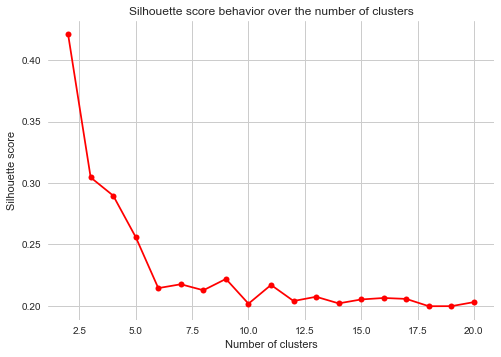

In [102]:
plt.plot(n_clusters, sc, marker='.', markersize=12, color='red')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score behavior over the number of clusters')
plt.show()

## Elbow method

In [103]:
for n, s in zip(n_clusters, ssd):
    print('Number of Clusters = {}, Sum of Squared Distances = {}'.format(n, s))

Number of Clusters = 2, Sum of Squared Distances = 222.28587596429753
Number of Clusters = 3, Sum of Squared Distances = 177.47220536349488
Number of Clusters = 4, Sum of Squared Distances = 154.881160159776
Number of Clusters = 5, Sum of Squared Distances = 138.91200061239624
Number of Clusters = 6, Sum of Squared Distances = 128.52430193903217
Number of Clusters = 7, Sum of Squared Distances = 119.63613386029624
Number of Clusters = 8, Sum of Squared Distances = 112.93278633475157
Number of Clusters = 9, Sum of Squared Distances = 107.2616991747567
Number of Clusters = 10, Sum of Squared Distances = 102.20414893405949
Number of Clusters = 11, Sum of Squared Distances = 97.49061294025698
Number of Clusters = 12, Sum of Squared Distances = 93.80806501706296
Number of Clusters = 13, Sum of Squared Distances = 89.35452071916782
Number of Clusters = 14, Sum of Squared Distances = 86.58575526803375
Number of Clusters = 15, Sum of Squared Distances = 83.53181133396583
Number of Clusters = 1

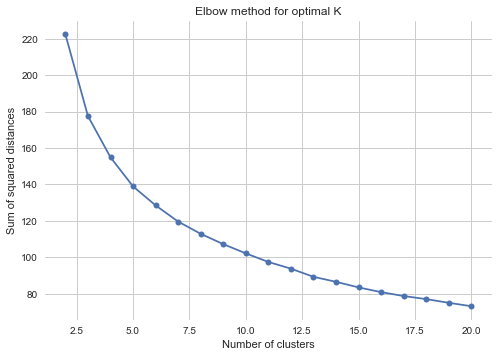

In [104]:
plt.plot(n_clusters, ssd, marker='.', markersize=12)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method for optimal K')
plt.show()

In [105]:
k=6
model = KMeans(n_clusters=k, random_state=42).fit(x_df_scaled)
pred = model.predict(x_df_scaled)
print('10 first clusters: ', model.labels_[:10])

10 first clusters:  [2 1 0 5 3 3 4 3 3 2]


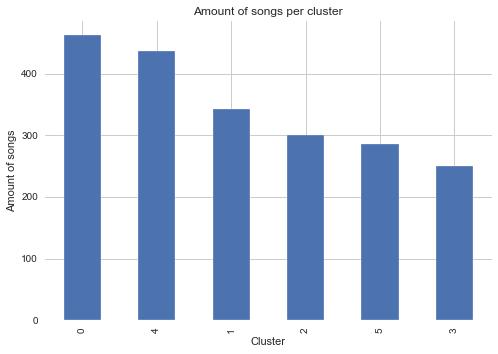

In [106]:
df['cluster'] = model.labels_

df['cluster'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Amount of songs')
plt.title('Amount of songs per cluster')
plt.show()

In [107]:
df_songs_joined = pd.concat([df,track], axis=1).set_index('cluster')

for cluster in range(k):
    display(df_songs_joined.loc[cluster, ['artist_name','track_name']].sample(frac=1).head(10))

,artist_name,track_name
cluster,,
0,BOBBY,HeartBROKEN PlaYBoY
0,ZICO,BERMUDA TRIANGLE
0,David Guetta,Let's Love
0,Epik High,헤픈엔딩 Happen Ending
0,Dan + Shay,"10,000 Hours (with Justin Bieber)"
0,Epik High,白夜
0,REFUND SISTERS,DON'T TOUCH ME
0,Verbal Jint,좋아보여 (feat. 검정치마)
0,Lee Soo Young,Grace


,artist_name,track_name
cluster,,
1,Crush,SOFA
1,Shin Seung Hun,You’re just at a higher place than me
1,이현우,슬픔속에그댈지워야만해
1,"Car, the garden",Tree
1,BEN,180 Degree
1,Sin Ye Young,why break up?
1,KATIE,하루하루
1,Jhené Aiko,Lead the Way
1,Gummy,Fade Away


,artist_name,track_name
cluster,,
2,Realslow,불치병
2,Charlie Puth,One Call Away
2,Rex Orange County,AMAZING
2,DAVICHI,사고쳤어요
2,Taylor Swift,cardigan
2,Land of Peace,Indica (feat. Motte)
2,Johnny Stimson,T-shirt
2,Yoon Do Hyun,I Guess I Loved You
2,BOL4,Travel


,artist_name,track_name
cluster,,
3,Lil Tjay,In My Head
3,Standing Egg,오래된 노래
3,Halsey,You should be sad
3,Lil Nas X,SUN GOES DOWN
3,Natalie Holt,Pruned
3,Phil Yoon,Pray On A Rope
3,Band Nah,Are You There?
3,Khalid,Scenic Drive (feat. Ari Lennox & Smino)
3,ZAYN,Dusk Till Dawn (feat. Sia) - Radio Edit


,artist_name,track_name
cluster,,
4,EXO,LOVE ME RIGHT
4,Sunny Hill,Midnight Circus
4,JINUSEAN,Tell Me One More Time
4,Roo'RA,날개 잃은 천사
4,SHINee,Dream Girl
4,SHINHWA,너의 결혼식 Wedding
4,Bruno Mars,Treasure
4,Brown Eyed Girls,Abracadabra (Dondake Beauty Mix)
4,Elton John,Cold Heart - PNAU Remix


,artist_name,track_name
cluster,,
5,BEN,Blank
5,John Park,The Day You were Falling
5,SOYOU,I Miss You
5,Shin Hye Sung,After Love
5,Paul Kim,사랑 알 수 없나봐 Inexplicable
5,Kim Gun Mo,A Beautiful Farewell
5,Yozoh,Quince Tree
5,Huh Gak,Along the Days
5,HOMIES,사이렌


In [108]:
df_radar = df.groupby('cluster').mean().reset_index()
df_radar

,cluster,danceability_scaled,energy_scaled,acousticness_scaled,valence_scaled,tempo_scaled
0,0,0.391779,0.775592,0.090634,0.515573,0.581120
1,1,0.448766,0.508529,0.621134,0.258426,0.606908
2,2,0.391126,0.628792,0.458988,0.633838,0.534191
3,3,0.403131,0.528186,0.199816,0.282564,0.564160
4,4,0.394855,0.825798,0.108929,0.825242,0.595223
5,5,0.409917,0.326868,0.821322,0.318840,0.519228


In [109]:
def make_radar(row, title, color, dframe, num_clusters):
    # number of variable
    categories=list(dframe)[1:]
    N = len(categories)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the radar plot
    #ax = plt.subplot(4,ceil(num_clusters/4),row+1, polar=True, )
    ax = plt.subplot(2,ceil(num_clusters/2),row+1, polar=True, )
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=14)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=8)
    plt.ylim(0,1)

    # Ind1
    values=dframe.loc[row].drop('cluster').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=16, color=color, y=1.06)

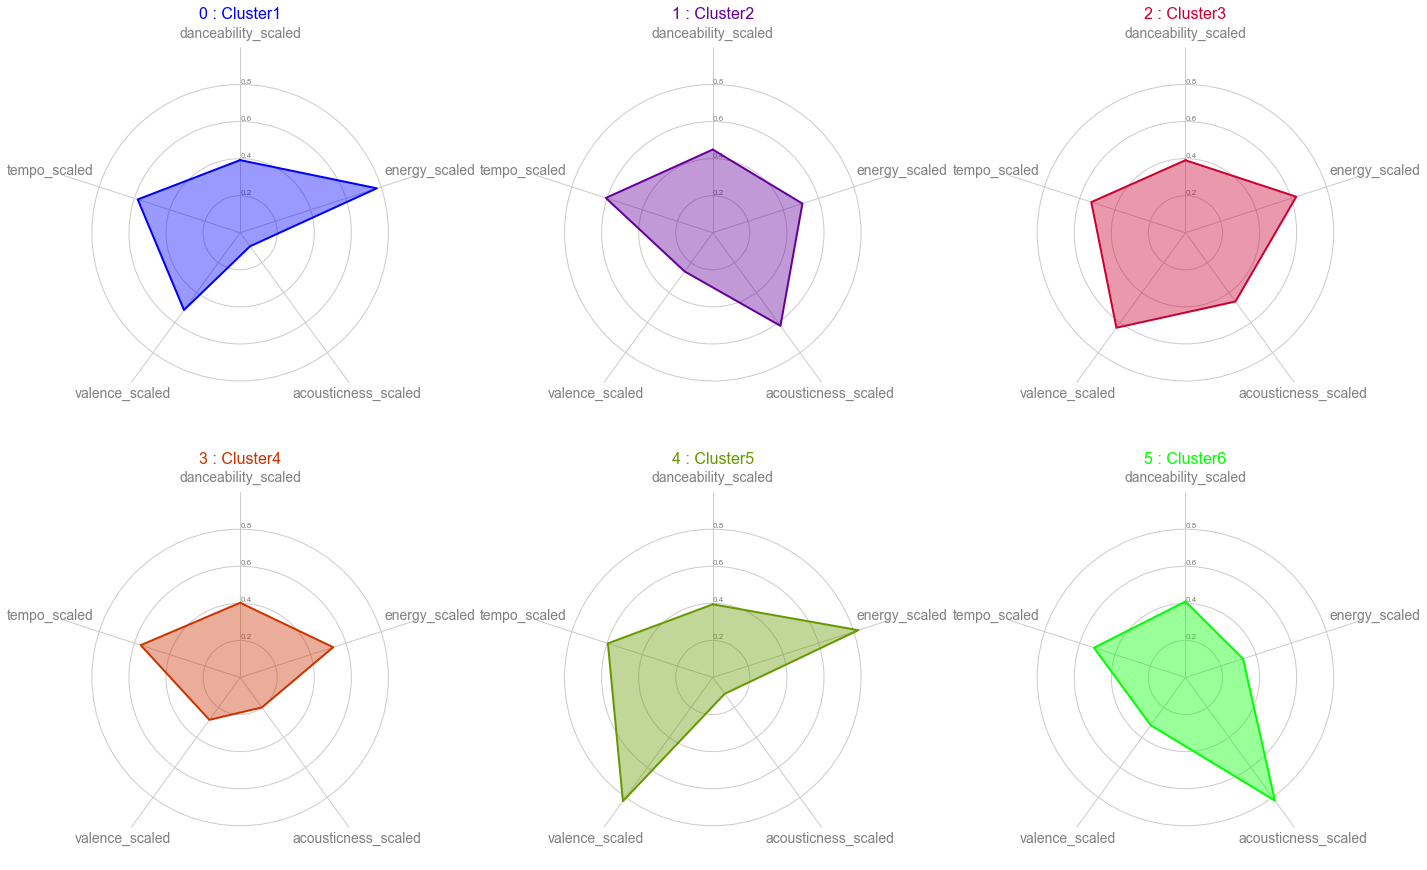

In [110]:
# initialize the figure
plt.figure(figsize=(24,15))
 
# Create a color palette:
my_palette = plt.cm.get_cmap("brg", len(df_radar.index))

# Create cluster name
title_list = ['Cluster1', 'Cluster2', 'Cluster3', 'Cluster4', 
              'Cluster5', 'Cluster6']

# Loop to plot
for row in range(0, len(df_radar.index)):
    make_radar(row=row, title=str(df_radar['cluster'][row]) + ' : ' + title_list[row], 
               color=my_palette(row), dframe=df_radar, num_clusters=len(df_radar.index))

0.9051152070099272


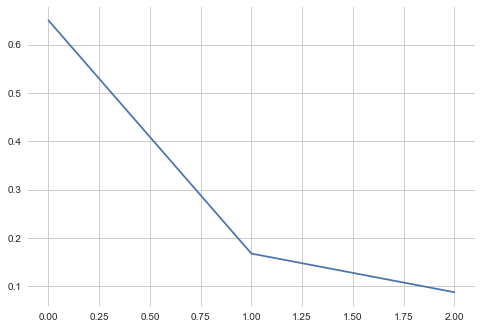

In [111]:
pca = PCA(n_components=3, random_state=42)
songs_pca = pca.fit_transform(x_df_scaled)
print(pca.explained_variance_ratio_.sum())
plt.plot(pca.explained_variance_ratio_)

In [112]:
df_pca = pd.DataFrame(songs_pca, columns=['C1', 'C2', 'C3'])
df_pca['cluster'] = model.labels_
minor_cluster = df['cluster'].value_counts().tail(1)
sampled_clusters_pca = pd.DataFrame()

for c in df_pca.cluster.unique():
    df_cluster_sampled_pca = df_pca[df_pca.cluster == c].sample(n=int(minor_cluster), random_state=42)
    sampled_clusters_pca = pd.concat([sampled_clusters_pca,df_cluster_sampled_pca], axis=0)
sampled_clusters_pca.cluster.value_counts()

2    250
1    250
0    250
5    250
3    250
4    250
Name: cluster, dtype: int64

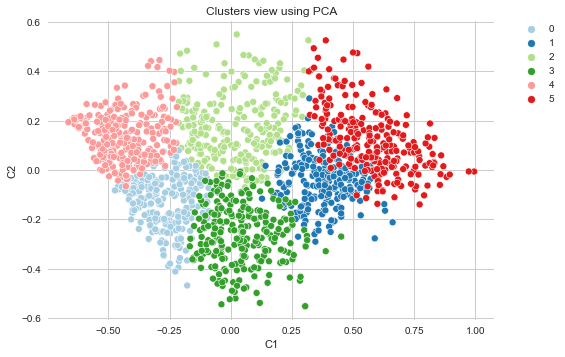

In [113]:
sns.scatterplot(x='C1', y='C2', hue='cluster', data=sampled_clusters_pca, legend="full", palette='Paired')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Clusters view using PCA')
plt.show()

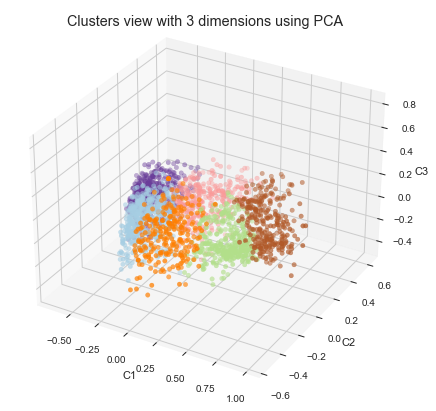

In [114]:
fig = plt.figure()
fig.suptitle('Clusters view with 3 dimensions using PCA')
ax = Axes3D(fig)

ax.scatter(df_pca['C1'], df_pca['C2'], df_pca['C3'],
           c=df_pca['cluster'], cmap='Paired')

ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_zlabel('C3')
plt.show()

## Predict which Cluster the User's playlist belongs to

In [115]:
user_pred = model.predict(x_user_scaled)
print('User Playlist clusters: ', user_pred)

User Playlist clusters:  [4 4 5 0 4 5 4 5 5 5]


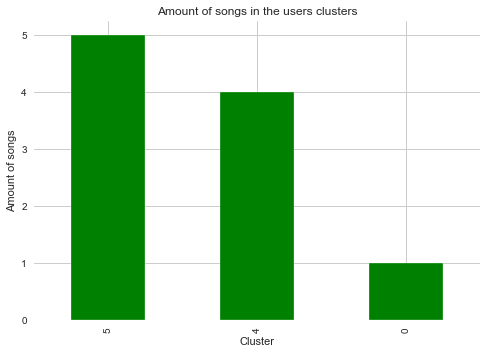

In [116]:
user_cluster = pd.DataFrame(x_user_scaled, columns=columns_scaled)
user_cluster['cluster'] = user_pred

user_cluster['cluster'].value_counts().plot(kind='bar', color='green')
plt.xlabel('Cluster')
plt.ylabel('Amount of songs')
plt.title('Amount of songs in the users clusters')
plt.show()

In [117]:
user_play_r = user_play.reset_index(drop=True)
df_user_songs_joined = pd.concat([user_cluster,user_play_r], axis=1).set_index('cluster')
for cluster in user_cluster['cluster'].unique():
    display(df_user_songs_joined.loc[cluster, ['artist_name','track_name']].sample(frac=1))

,artist_name,track_name
cluster,,
4,EXO,Baby
4,SUPER JUNIOR,Mamacita (아야야)
4,Ed Sheeran,Shivers
4,TWICE,What is Love


,artist_name,track_name
cluster,,
5,Shin Giwon Piano,You and I
5,MeloMance,Better for Me (Nth Romance X MeloMance)
5,Standing Egg,friend to lover
5,IU,Only I didn't know
5,Kim Dong Ryul,Old Song


artist_name                      SHINee
track_name     누난 너무 예뻐 (Replay) - Live
Name: 0, dtype: object

In [118]:
df_user_songs_joined.reset_index(inplace=True)
cluster_pct = df_user_songs_joined.cluster.value_counts(normalize=True)*20

if int(cluster_pct.round(0).sum()) < 20:
    cluster_pct[cluster_pct < 0.5] = cluster_pct[cluster_pct < 0.5] + 1.0
    
display(cluster_pct)

5    10.0
4     8.0
0     2.0
Name: cluster, dtype: float64

In [119]:
df_user_songs_joined['cluster_pct'] = df_user_songs_joined['cluster'].apply(lambda c: cluster_pct[c])
df_user_songs_joined.drop(columns=columns_scaled, inplace=True)
df_user_songs_joined.head(3)

,cluster,index,Unnamed: 0,id,artist_name,track_name,album_name,artist_genre,release_date,artist_popularity,...,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre,euclidean_distance,cos_similarity,cluster_pct
0,4,776,944,3pnvvqhkOYq0kTgLaT4BCA,EXO,Baby,The 1st Album 'XOXO' (Repackage),"['k-pop', 'k-pop boy group']",2013-08-05,69,...,0.000,0.0905,0.759,137.956,238011,4,"kpop, kpop boy group",0.111232,0.263778,8.0
1,4,476,595,5kzFg2B9IcXt41Nwqmr9Eg,SUPER JUNIOR,Mamacita (아야야),THE 7th Album 'MAMACITA',"['k-pop', 'k-pop boy group']",2014-08-29,58,...,0.000,0.0702,0.697,101.564,207744,4,"kpop, kpop boy group",0.236706,0.263778,8.0
2,5,88,88,0G5vfSwmepxhObl1ZnkH6p,Shin Giwon Piano,You and I,IU Music Piano Collection,['korean instrumental'],2019-11-26,48,...,0.927,0.1190,0.139,134.020,245373,4,korean instrumental,1.204731,0.000000,10.0


In [120]:
df_songs_joined = df_songs_joined.reset_index(drop=False)
playlist = pd.DataFrame()

for ncluster, pct in cluster_pct.items():
    songs = df_songs_joined[df_songs_joined['cluster'] == ncluster].sample(n=int(round(pct, 0)))
    playlist = pd.concat([playlist,songs], ignore_index=True)
    if len(playlist) > 20 :
        flag = 20 - len(playlist)
        playlist = playlist[:flag]
playlist[['artist_name', 'track_name', 'cluster']]

,artist_name,track_name,cluster
0,Bobby Kim,Intoxicated,5
1,Harry Styles,Falling,5
2,Sarah Barrios,Have We Met Before (with Eric Nam),5
3,IU,Drama,5
4,Lim Young Woong,If I Love Again (Feel Kim Ver.),5
5,J_ust,I Want to Be A Pillow,5
6,Christophe Beck,2012,5
7,Jung Seung Hwan,응급실,5
8,Lena Park,이젠 그랬으면 좋겠네,5
9,Urban Zakapa,YOU TOUCHED MY HEART,5


In [121]:
user_play[['artist_name', 'track_name']]

,artist_name,track_name
728,EXO,Baby
444,SUPER JUNIOR,Mamacita (아야야)
87,Shin Giwon Piano,You and I
1623,SHINee,누난 너무 예뻐 (Replay) - Live
1452,TWICE,What is Love
76,IU,Only I didn't know
35,Ed Sheeran,Shivers
943,Standing Egg,friend to lover
1900,Kim Dong Ryul,Old Song
1127,MeloMance,Better for Me (Nth Romance X MeloMance)


# Song2Vec
- 유저의 playlist를 기반으로 추천을 해줌

In [156]:
# 일단 유저의 playlist가 없으니 랜덤으로 우리 track에서 20개정도 뽑은걸 user의 playlist라 가정하겠음
user_play = track.sample(n=20)
user_play.shape

(20, 25)

In [79]:
import ast
corpus = track['genre']
corpus = list(corpus)
genre_sequences = list(corpus)
flat_corpus = [item for sublist in genre_sequences for item in sublist] # list of every occurance of every genre
genres = set(flat_corpus) # set of all genres present in the corpus
df = pd.DataFrame(flat_corpus)
genre_sequences
df

,0
0,p
1,o
2,p
3,a
4,r
...,...
46820,k
46821,r
46822,o
46823,c


In [53]:
playlist = track[['artist_name', 'track_name', 'genre']]
playlist['sentence'] = new_track['artist_name'] + " " + new_track['track_name'] + " " + new_track['genre']
playlist['sentence'] = new_track['sentence'].astype('str')
playlist = playlist.drop(['artist_name', 'track_name', 'genre'], axis=1)

clean_playlist = [p for p in playlist['sentence'] if len(p) > 1]
print(f"Playlist Count After Cleansing: {len(clean_playlist)}")

Playlist Count After Cleansing: 2077


In [54]:
playlist_train, playlist_test = train_test_split(clean_playlist, test_size = 1000,
                                                 shuffle = True, random_state = 123)

In [29]:
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)

class Callback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 1
        self.training_loss = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 1:
            current_loss = loss
        else:
            current_loss = loss - self.loss_previous_step
        print(f"Loss after epoch {self.epoch}: {current_loss}")
        self.training_loss.append(current_loss)
        self.epoch += 1
        self.loss_previous_step = loss

In [58]:
model = Word2Vec(vector_size = 30, window = 5, min_count = 1,
                 sg = 0, negative =20, workers = multiprocessing.cpu_count()-1)
print(model)

2022-06-21 22:04:14,784 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=30, alpha=0.025)', 'datetime': '2022-06-21T22:04:14.784199', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}


Word2Vec(vocab=0, vector_size=30, alpha=0.025)


In [59]:
logging.disable(logging.NOTSET) # enable logging
t = time()

model.build_vocab(playlist_train)

2022-06-21 22:04:15,611 : INFO : collecting all words and their counts
2022-06-21 22:04:15,611 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2022-06-21 22:04:15,617 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-06-21 22:04:15,661 : INFO : collected 387 word types from a corpus of 52113 raw words and 1077 sentences
2022-06-21 22:04:15,662 : INFO : Creating a fresh vocabulary
2022-06-21 22:04:15,690 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 387 unique words (100.0%% of original 387, drops 0)', 'datetime': '2022-06-21T22:04:15.690320', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'prepare_vocab'}
2022-06-21 22:04:15,699 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 52113 word corpus (100.0%% of original 52113, d

# Collaborative Filtering Recommender
- When there are enough users